In [2]:
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import copy
from time import time
from tqdm.notebook import tqdm
import os

### Ниже реализуем алогритмы, а также используем библиотеку NetworkX для визуализации графов.

In [3]:

class num_set:
    def __init__(self, values):
        self.values = set(values)


    def __lt__(self, other):
        if len(self.values) == 0 and len(other.values) != 0:
            return True
        elif len(self.values) != 0 and len(other.values) != 0 and \
        max(self.values) < max(other.values):
            return True
        elif len(self.values) != 0 and len(other.values) != 0 and \
        max(self.values) == max(other.values) and \
        num_set(self.values - set([max(self.values)])) < num_set(other.values - set([max(other.values)])):
            return True
        else:
            return False



# E - матрица смежности
def Coffman_Graham(E, W, V):
    # количество вершин
    n = len(E)
    pi = [None] * n
    for i in range(n):
        minset = num_set(V)
        for v in range(n):
            if pi[v] is None:
                v_is_good = True
                curset = []
                for u in range(n):
                    if E[u][v] == 1:
                        if pi[u] is None:
                            #плохо, берем новое v
                            v_is_good = False
                            break
                        else:
                            curset.append(pi[u])
                curset = num_set(curset)
                if v_is_good and curset < minset:
                    minset = curset
                    v_min = v   
        pi[v_min] = i
    #вторая часть алгоритма
    k = 0
    L = [[]]
    U = []
    while frozenset(U) != frozenset(V):
        pi_u_max = -1
        for u in set(V) - set(U):
            u_is_good = True
            for v in V:
                if E[u][v] == 1:
                    if v not in U:
                        u_is_good = False
                        break
                    
            if u_is_good and pi[u] > pi_u_max:
                pi_u_max = pi[u]
                u_max = u
        u = u_max
        L_prev = []
        for i in range(k):
            L_prev = L_prev + L[i]
        
        check = True
        for w in V:
            if E[u][w] == 1 and w not in L_prev:
                check = False 
            
        if check and len(L[k]) < W:
            L[k].append(u)
        else:
            k = k + 1
            L.append([u])
        U.append(u)
    return L
      

def Greedy_Algorithm(E, W, V):
    k = 0
    L = [[]]
    U = []
    n = len(E)
    while frozenset(U) != frozenset(V):
        success = False
        u_good = None
        for u in set(V) - set(U):
            u_is_good = True
            for v in V:
                if E[u][v] == 1:
                    if v not in U:
                        u_is_good = False
                        break
                    
            if u_is_good:
                u_good = u
                L_prev = []
                for i in range(k):
                    L_prev = L_prev + L[i]
                
                check = True
                for w in V:
                    if E[u][w] == 1 and w not in L_prev:
                        check = False 
                    
                if check and len(L[k]) < W:
                    L[k].append(u)
                    success = True
                    break
        if not success:
            k = k + 1
            L.append([u_good])
        U.append(u_good)
    return L


def get_pi(E):
    n_len = len(E)
    pi = [None] * n_len
    for i in range(n_len):
        minset = num_set(range(n_len))
        for v in range(n_len):
            if pi[v] is None:
                v_is_good = True
                curset = []
                for u in range(n_len):
                    if E[u][v] == 1:
                        if pi[u] is None:
                            #плохо, берем новое v
                            v_is_good = False
                            break
                        else:
                            curset.append(pi[u])
                curset = num_set(curset)
                if v_is_good and curset < minset:
                    minset = curset
                    v_min = v   
            
        pi[v_min] = i
    return pi


def get_U_(V, U, E):
    U_ = []
    for u in set(V) - set(U):
        u_is_good = True
        for v in V:
            if E[u][v] == 1:
                if v not in U:
                    u_is_good = False
                    break
                
        if u_is_good:
            U_.append(u)       
    return U_

def get_empty_k_U_L(l):
    k_cur = []
    L_cur = []
    U_cur = []
    for i in range(l):
        k_cur.append([])
        U_cur.append([])
        L_cur.append([])
        for j in range(l):
            k_cur[i].append([])
            U_cur[i].append([])
            L_cur[i].append([[]])
    return k_cur, U_cur, L_cur

def get_u(j, U_, pi, u_best):
    u_new = None
    if j < len(U_):
        pi_u_max = -1
        for u in U_:
            if u not in u_best and pi[u] > pi_u_max:
                pi_u_max = pi[u]
                u_max = u
        u_new = u_max
    else:
        u_new = u_best[len(U_) - 1]
    return u_new

def get_check(k, E, L, V, u, i, j):
    L_prev = []
    for f in range(k[i]):
        L_prev = L_prev + L[i][j][f]
    check = True
    for w in V:
        if E[u][w] == 1 and w not in L_prev:
            check = False   
            break  
    return check

def get_two_mins_and_argmins(n_len, I, k, l):
    k_min = n_len
    k_second_min = n_len
    m = n = None
    m_ = n_ = None
    for i in range(l):
        for j in range(l):
            if I[i][j] == 1 and k[i][j] < k_min:
                k_second_min = k_min
                k_min = k[i][j]
                m_ = m
                n_ = n
                m = i
                n = j
    return k_min, k_second_min, (m, n), (m_, n_)


def get_new_argmins(I, n_len, m, n, k, L, l):
    L_min_len = n_len
    for i in range(l):
        for j in range(l):
            L_len = len(L[i][j][k[i][j]])
            if I[i][j] == 1 and k[i][j] == k[m][n] and L_len < L_min_len:
                L_min_len = L_len
                m = i, n = j
    return (m, n)

def get_new_I(I, k, L, m, n, l):
    for i in range(l):
        for j in range(l):
            if k[i][j] == k[m][n]:
                equal = True
                for p in range(k[i][j] + 1):
                    if frozenset(L[i][j][p]) != frozenset(L[m][n][p]):
                        equal = False
                        break
                if equal:
                    I[i][j] = 0   
    return I
   

def modify_k_U_L(k, U, L, k_cur, U_cur, L_cur, n_len, l):
    I = np.ones((l, l))
    k_old = list(k)
    for f in range(l):
        if I.sum() > 0:
            k_min, k_second_min, (m, n), (m_, n_) \
            = get_two_mins_and_argmins(n_len, I, k_cur, l)
            if k_min == k_second_min:
                (m, n) = get_new_argmins(I, n_len, m, n, k_cur, L_cur, l)
        U[f] = U_cur[m][n]
        k[f] = k_cur[m][n]
        L[f] = [list(l) for l in L_cur[m][n]]

        I = get_new_I(I, k_cur, L_cur, m, n, l)


def Coffman_Graham_Modification(E, W, V, l=2):
    n_len = len(E)
    pi = get_pi(E)
    k = [0] * l
    L = [[[]] for i in range(l)]
    U = [[] for i in range(l)]
    V = range(n_len)
    while frozenset(U[0]) != frozenset(V):
        k_cur, U_cur, L_cur = get_empty_k_U_L(l)
        for i in range(l):
            U_ = get_U_(V, U[i], E)
            u_best = [None] * l
            for j in range(l):
                u = get_u(j, U_, pi, u_best)
                u_best[j] = u
                k_cur[i][j] = k[i]
                U_cur[i][j] = list(U[i])
                L_cur[i][j] = [list(L_i) for L_i in L[i]]

                check = get_check(k, E, L_cur, V, u, i, j)
                if len(L_cur[i][j][k_cur[i][j]]) < W and check:
                    L_cur[i][j][k_cur[i][j]].append(u)
                else:
                    k_cur[i][j] += 1
                    L_cur[i][j].append([u])
                U_cur[i][j].append(u)
        modify_k_U_L(k, U, L, k_cur, U_cur, L_cur, n_len, l)
        L_all = [elem for l in L[0] for elem in l]
        
    return L[0]

def Add_dummy_verteces(E, V, L, G):
    new_vertex = max(V) + 1
    V_add = []
    L_add = [[] for i in range(len(L))]
    edges_add = []
    remove_edges = []
    for i in range(len(L)):
        for j in range(i + 2, len(L)):
            for u in L[j]:
                for v in L[i]:
                    if E[u][v] == 1:
                        prev_vertex = u
                        for k in range(j - 1, i, -1):
                            L_add[k].append(new_vertex)
                            V_add.append(new_vertex)
                            edges_add.append([prev_vertex, new_vertex])
                            prev_vertex = new_vertex
                            new_vertex += 1
                        edges_add.append([prev_vertex, v])
                        remove_edges.append([u, v])
    # G.add_node - добавляет вершину к графу (чтобы добавить фиктивную вершину)
    # G.add_edge - добавляет ребро к графу (чтобы добавить путь из фиктивных вершин)
    G_new = nx.DiGraph(G)
    G_new.add_edges_from(edges_add)
    G_new.remove_edges_from(remove_edges)
    
    E_new = copy.deepcopy(E)
    for (u, v) in remove_edges:
        E_new[u][v] = 0

    edges = get_edges_from_E(E_new)

    V_new = V + V_add
    E_new = get_E_from_edges(edges + edges_add, len(V_new))
    L_new = [L[i] + L_add[i] for i in range(len(L))]
    is_dummy = {v: (v in V_add) for v in V + V_add}
    return E_new, V_new, L_new, G_new, is_dummy
    
                        

E = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 1],
    [0, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0]
])


def get_edges_from_E(E):
    edges = []
    for u in range(len(E)):
        for v in range(len(E[u])):
            if E[u][v] == 1:
                edges.append([u, v])
    return edges


def get_E_from_edges(edges, n, directed=True):
    E = np.zeros((n, n))
    if isinstance(edges, dict):
        for u in edges:
            for v in edges[u]:
                E[u][v] = 1
                if not directed:
                    E[v][u] = 1
    else:
        for (u, v) in edges:
            E[u][v] = 1
            if not directed:
                E[v][u] = 1
    return E

n = 10
edges = {
    0: [2, 3],
    2: [7, 9],
    3: [7, 8, 5],
    4: [8],
    7: [9]
}
E = get_E_from_edges(edges, n, directed=True)


# тут L_2 - множество вершин, C - матрица значений c_vu, а x_2 - порядок вершин
# в слое  L_2


def find_c(E, L1, L2):
    c = [([0] * len(L2)) for i in range(len(L2))]
    for i in range(len(L2)):
        u = L2[i]
        for j in range(i + 1, len(L2)):
            v = L2[j]
            for k in range(len(L1)):
                z = L1[k]
                for l in range(k + 1, len(L1)):
                    w = L1[l]
                    if E[u][w] and E[v][z]:
                        c[i][j] = c[i][j] + 1 
                    if E[u][z] and E[v][w]:
                        c[j][i] = c[j][i] + 1

    return c

edges = {
    0: [4, 7],
    1: [5, 6, 7, 10],
    2: [4, 8, 9, 10],
    3: [6, 7]
}

n = 11
E = get_E_from_edges(edges, n)



def Adjacent_Exchange(E, L1, L2):
    # порядок в L2 уже задан, тк это массив
    # в L2 лежат номера вершин в соответстивии с матрицей Е
    # число пересечений общее
    c = find_c(E, L1, L2)
    cross_reduce = True
    x2 = list(range(len(L2)))
    while cross_reduce:
        # i соответствует u, i+1 соответствует v
        cross_reduce = False
        for i in range(len(L2) - 1):
            if c[x2[i]][x2[i+1]] > c[x2[i+1]][x2[i]]:
                cross_reduce = True
                # swap 
                x2[i], x2[i+1] = x2[i+1], x2[i]

    return x2


# тут L_2 - множество вершин, C - матрица значений c_vu, а x_2 - порядок вершин
# в слое  L_2


def Split(E, L1, L2, x2=None, c=None):
    if x2 is None:
        x2 = list(range(len(L2)))
    if len(x2) == 0:
        return []
    if len(x2) == 1:
        return x2

    if c is None:
        c = find_c(E, L1, L2)
    j = len(x2)//2
    p = L2[x2[j]]
    x2_left = []
    x2_right = []
    for i, k in enumerate(x2):
        u = L2[k]
        if u != p:
            if c[x2[i]][x2[j]] <= c[x2[j]][x2[i]]:
                x2_left.append(k)
            else:
                x2_right.append(k)
    x2 = Split(E, L1, L2, x2_left, c) + [x2[j]] + Split(E, L1, L2, x2_right, c)

    return x2



edges = {
    1: [3, 5],
    2: [3, 4],
    0: [4]
}

E = get_E_from_edges(edges, 6)
L1 = list(range(3, 6))
L2 = list(range(3))


def Barycenter(E, L1, L2):
    x2 = np.array(range(len(L2)))
    avg = np.empty_like(x2)
    for j, u in enumerate(L2):
        sum = 0
        deg = 0
        for i, v in enumerate(L1):
            if E[u][v] == 1:
                sum = sum + i
                deg = deg + 1
        if deg > 0:
            avg[j] = sum // deg
        else:
            avg[j] = 0
    
    # хотим остортировать x2 по avg:
    indices = avg.argsort()
    x2 = x2[indices]

    return x2.tolist()


def Median(E, L1, L2):
    x2 = list(range(len(L2)))
    medians = [0] * len(L2)
    is_even = [0] * len(L2)
    for i, u in enumerate(L2):
        neighbors = []
        for j, v in enumerate(L1):
            if E[u][v] == 1:
                neighbors.append(j)
        neighbors = sorted(neighbors)
        is_even[i] = (len(neighbors) % 2 == 0)
        if neighbors:
            medians[i] = neighbors[len(neighbors)//2]

    values = [(medians[i], is_even[i], x2[i]) for i in range(len(L2))]
    x2 = [elem[2] for elem in sorted(values)]

    return x2


def Upgraded_Mediana(E, L1, L2):
    avg = np.empty_like(L2)
    for j, u in enumerate(L2):
        sum = 0
        deg = 0
        for i, v in enumerate(L1):
            if E[u][v] == 1:
                sum = sum + i
                deg = deg + 1
        if deg > 0:
            avg[j] = sum // deg
        else:
            avg[j] = 0


    x2 = list(range(len(L2)))
    medians = [0] * len(L2)
    for i, u in enumerate(L2):
        neighbors = []
        for j, v in enumerate(L1):
            if E[u][v] == 1:
                neighbors.append(j)
        neighbors = sorted(neighbors)
        if neighbors:
            medians[i] = neighbors[len(neighbors)//2]
        
    values = [(medians[i], avg[i], x2[i]) for i in range(len(L2))]
    x2 = [elem[2] for elem in sorted(values)]

    return x2


def Upgraded_adjacent_exchange(E, L1, L2):
    x2 = Upgraded_Mediana(E, L1, L2)
    L2_new = list(L2)
    x_final = range(len(L2))

    L2_new = np.array(L2_new)[x2].tolist()
    x_final = np.array(x_final)[x2].tolist()
    x2 = Adjacent_Exchange(E, L1, L2_new)
    x_final = np.array(x_final)[x2].tolist()   
    return x_final


def Count_crossings_two_layers(E, L1, L2, x1, x2):
    crossings = 0
    c = find_c(E, np.array(L1)[x1].tolist(), np.array(L2)[x2].tolist())
    for i in range(len(L2)):
        for j in range(i + 1, len(L2)):
            crossings = crossings + c[i][j]
    return crossings


def Count_crossings(E, L, X):
    crossings = 0
    for i in range(len(L) - 1):
        L1 = list(L[i])
        L2 = list(L[i + 1])
        
        x1 = list(X[i])
        x2 = list(X[i + 1])
        crossings = crossings + Count_crossings_two_layers(E, L1, L2, x1, x2)
    return crossings


def Layer_by_layer_sweep(E, L, method=Split):
    x = []
    x.append(list(range(len(L[0]))))
    for i in range(len(L) - 1):
        L1 = list(L[i])
        L2 = list(L[i + 1])
        x1 = x[i]
        L1_new = np.array(L1)[x1].tolist()
        x2 = method(E, L1_new, L2)
        x.append(x2)

    return x


Изображение произвольного графа при помощи бибилотеки NetworkX.

Получим случайный ациклический орграф на заданном числе вершин и с заданной вероятнотью иметь ребро между парой вершин.

In [4]:
def get_random_graph(n, p):
    directed=True
    while True:
        G = nx.gnp_random_graph(n=n, p=p, directed=directed)
        if nx.is_directed_acyclic_graph(G):
            break
    return G


def create_best_draw(
    G,
    W=3,
    Layering=Coffman_Graham,
    Two_layer_reductor=Split):

    V = list(G.nodes)    
    E = get_E_from_edges(edges=G.edges(), n=len(V))
    times = {}
    # когда начали искать разбиение по слоям
    start = time()
    L = Layering(E, W, V)
    # когда закончили искать разбиение по слоям и начали добавлять dummy вершины
    end = time()
    times['Layering'] = end - start
    start = time()
    E, V, L, G, is_dummy = Add_dummy_verteces(E, V, L, G)
    # когда закончили добавлять dummy вершины и начали уменьшать число пересечений в слоях
    end = time()
    times['Add_dummy'] = end - start
    start = time()
    X = Layer_by_layer_sweep(E, L, Two_layer_reductor)
    # когда закончили уменьшать число пересечений в слоях
    end = time()
    times['Sweep'] = end - start
    return V, E, L, X, G, is_dummy, times


def get_draw_parameters(E, L, X):
    h = len(L)
    crossings = Count_crossings(E, L, X)
    return h, crossings


def draw(V, E, L, X, G, is_dummy):
    pos = {}
    for y in range(len(L)):
        for i, x in enumerate(X[y]):
            pos[L[y][x]] = [i, y]

    nx.draw_networkx(G, pos, arrows=False, 
                     edgelist=[edge for edge in G.edges if is_dummy[edge[1]]],                     
                     nodelist=[v for v in G.nodes if not is_dummy[v]], 
                     with_labels=False, node_size=30, node_color='black')
    nx.draw_networkx(G, pos, 
                     edgelist=[edge for edge in G.edges if (not is_dummy[edge[1]])],
                     nodelist=[v for v in G.nodes if not is_dummy[v]], 
                     with_labels=False, node_size=30, node_color='black')
    plt.show()

In [5]:
n = 20
def get_p(n):
    return 0.05
p = get_p(n)
G = get_random_graph(n, p)

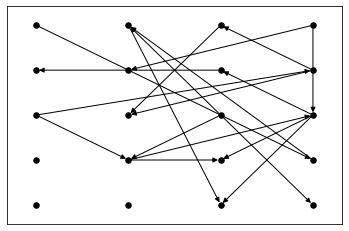

Layering: 0.00773
Add_dummy: 0.00133
Sweep: 0.00113
6 10


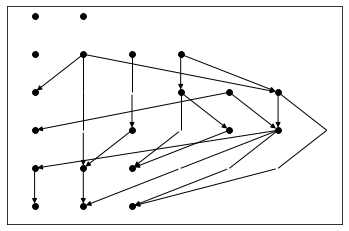

In [6]:
pos = {}
W = 4
for i in G.nodes:
    pos[i] = [i%W, i//W]

nx.draw_networkx(G, pos, with_labels=False, node_color='black', node_size=30)
plt.show()
V, E, L, X, G_new, is_dummy, times = create_best_draw(
    G=nx.DiGraph(G),
    W=W,
    Layering = Coffman_Graham,
    Two_layer_reductor=Split
    )
for name, exec_time in times.items():
    print(f'{name}: {round(exec_time, 5)}')
h, crossings = get_draw_parameters(E, L, X)
print(h, crossings)
draw(V, E, L, X, G_new, is_dummy)

Ниже проведем эксперименты с разными размерами массивов и разными комбинациями методов.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
reductors = [Split, Upgraded_adjacent_exchange]
layerings = [Coffman_Graham, Greedy_Algorithm, Coffman_Graham_Modification]


params = ['Layering_time', 'Add_dummy_time', 'Sweep_time', 'h', 'crossings']
num_experiments = 100
n_values = range(10, 30)
W_values = range(3, 7)
results = {
    reductor.__name__: {
        layering.__name__: {
            W: {
                param: np.empty((len(n_values), num_experiments)) for param in params
                } for W in W_values
                           } for layering in layerings
                       } for reductor in reductors
           }
for i, n in enumerate(tqdm(n_values)):
    for j in range(num_experiments):
        G = get_random_graph(n, get_p(n))
        for W in W_values:
            for reductor in reductors:
                reductor_name = reductor.__name__
                for layering in layerings:
                    layering_name = layering.__name__

                    V, E, L, X, G_new, is_dummy, times = create_best_draw(
                    G=nx.DiGraph(G),
                    W=W,
                    Layering=layering,
                    Two_layer_reductor=reductor
                    )
                    for key, value in times.items():
                        new_key = key + '_time'
                        results[reductor_name][layering_name][W][new_key][i, j] = value
                    results[reductor_name][layering_name][W]['h'][i, j], \
                    results[reductor_name][layering_name][W]['crossings'][i, j] \
                    = get_draw_parameters(E, L, X)

Степень зависимости (Coffman_Graham): 2.497348041910616
Степень зависимости (Greedy_Algorithm): 2.439090238022128
Степень зависимости (Coffman_Graham_Modification): 2.2147634068138364


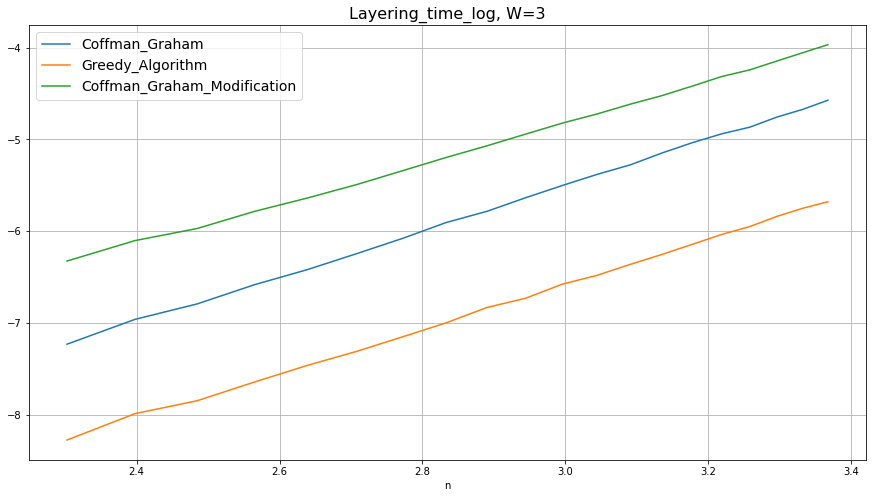

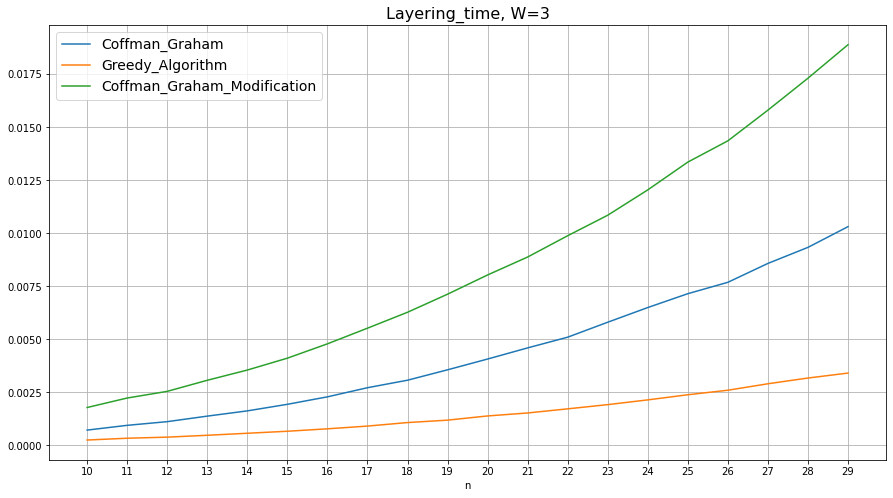

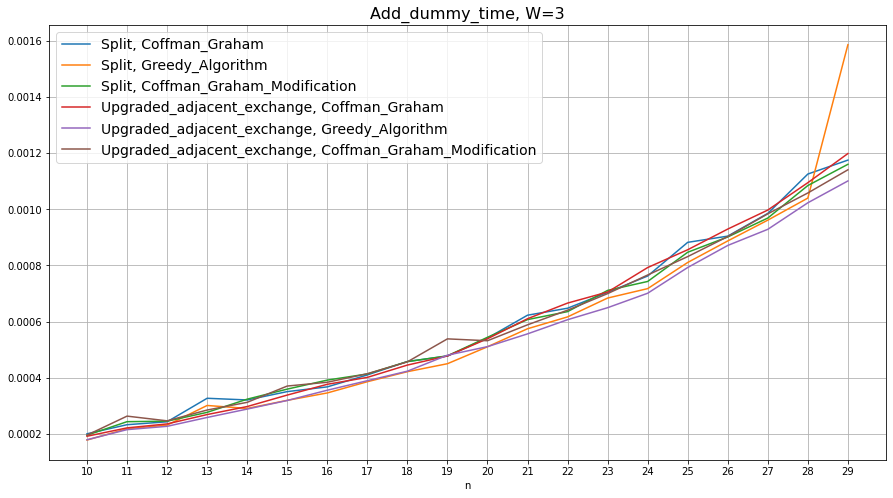

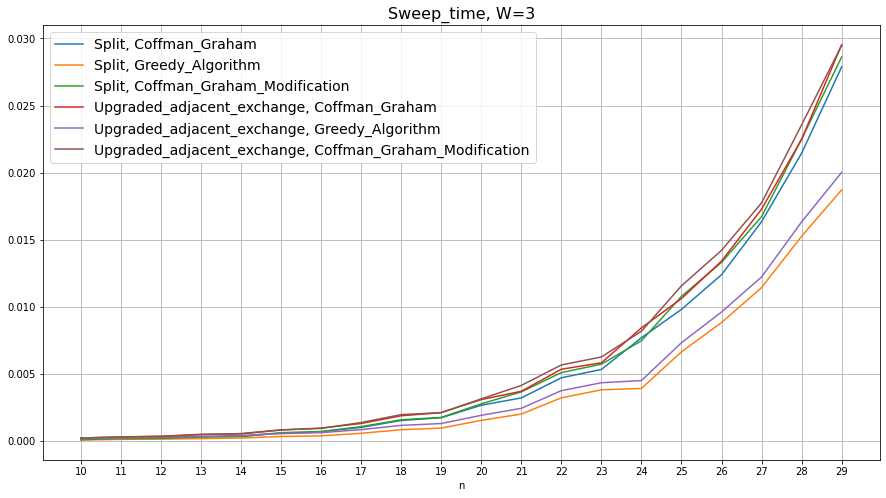

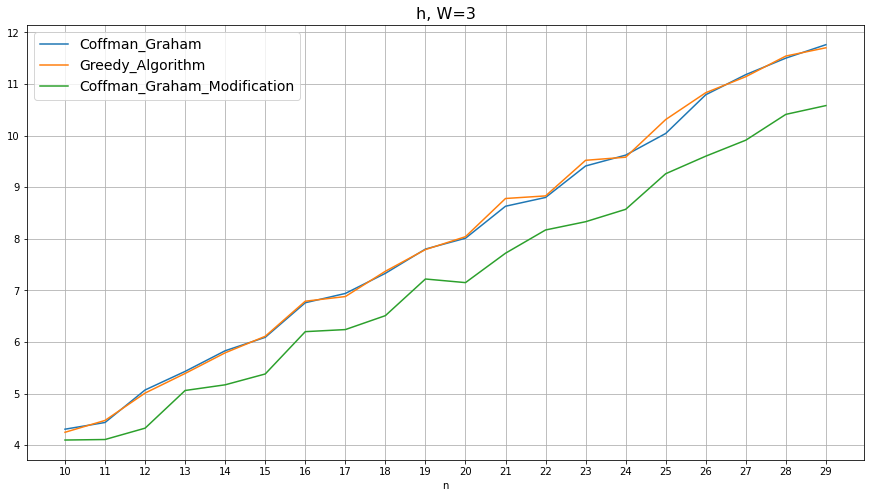

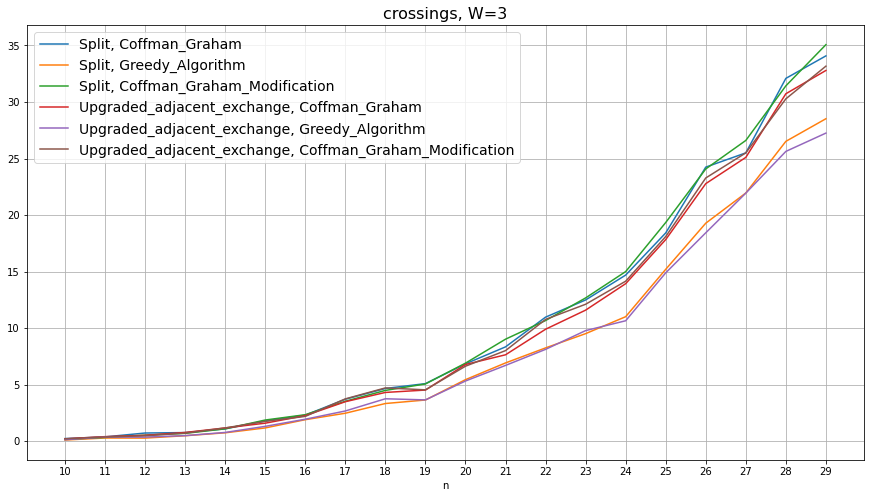

Степень зависимости (Coffman_Graham): 2.536744991545888
Степень зависимости (Greedy_Algorithm): 2.481396106780531
Степень зависимости (Coffman_Graham_Modification): 2.232680577253833


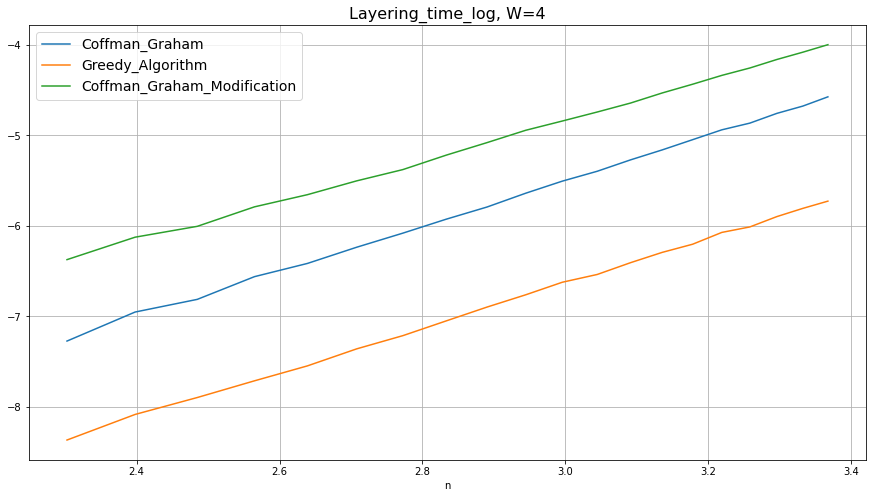

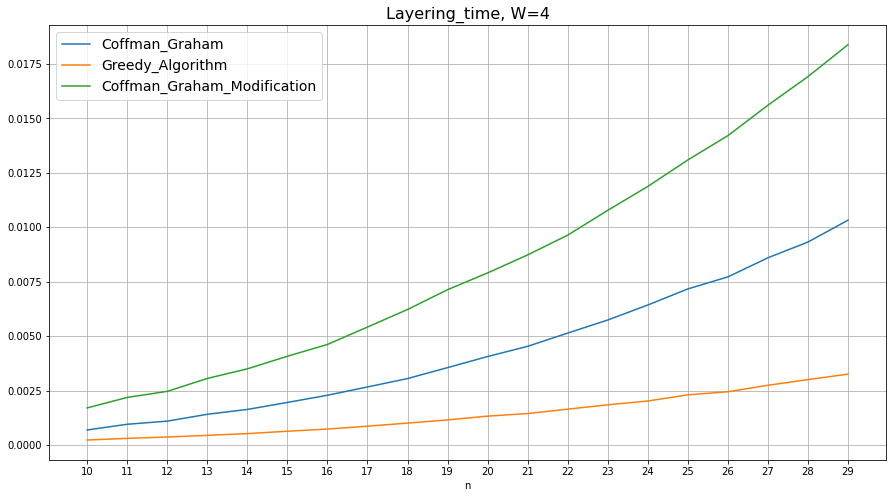

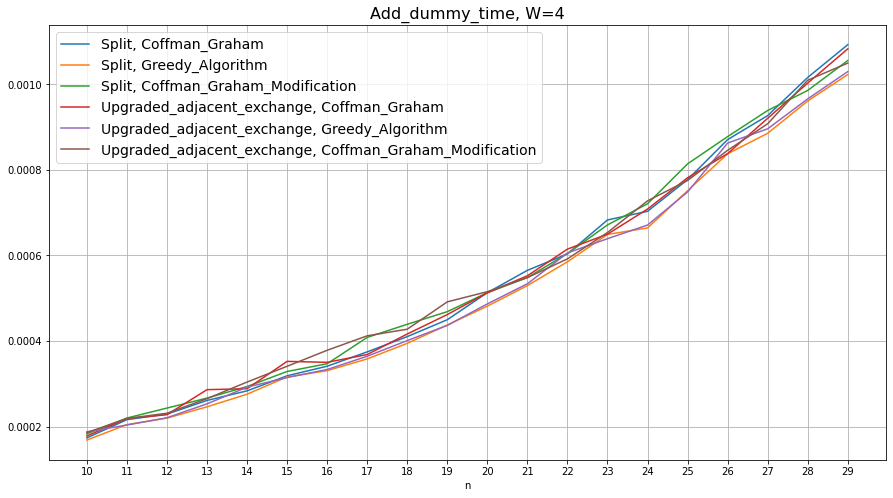

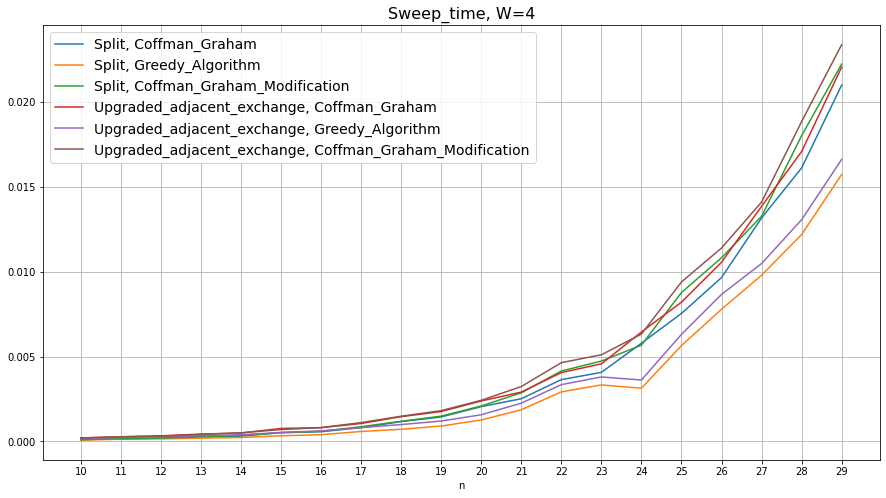

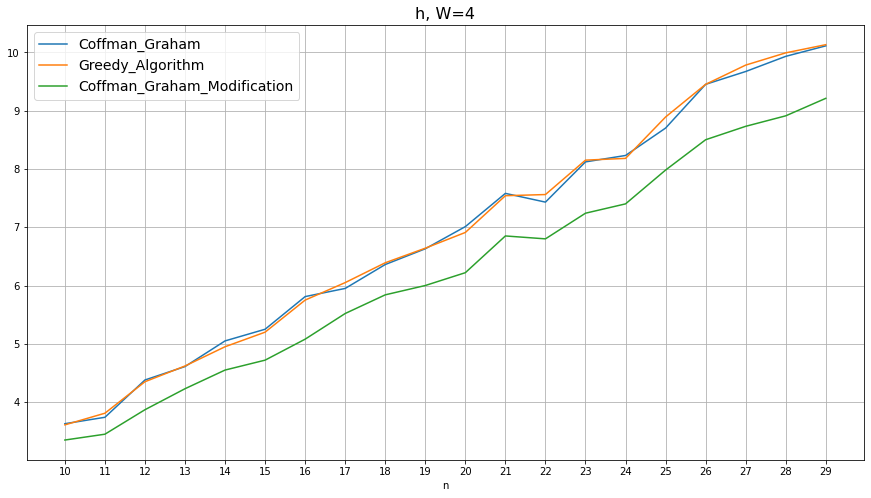

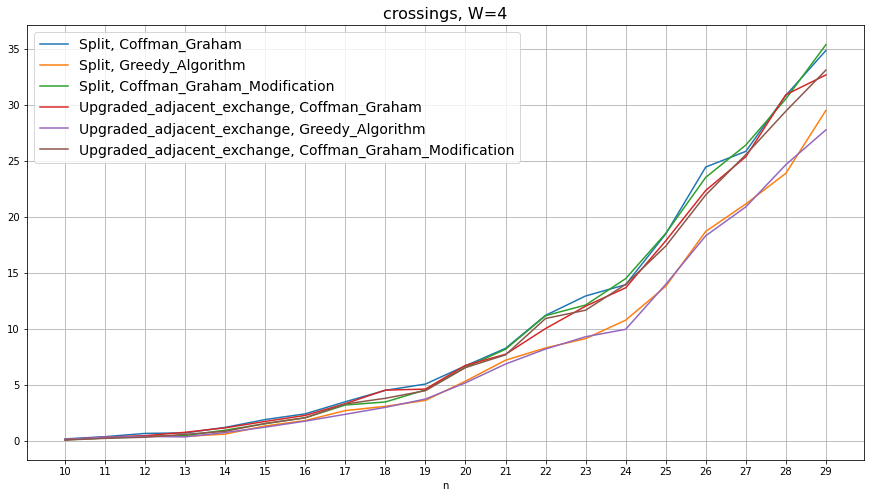

Степень зависимости (Coffman_Graham): 2.5076320072021128
Степень зависимости (Greedy_Algorithm): 2.4489918455619035
Степень зависимости (Coffman_Graham_Modification): 2.2086883830148785


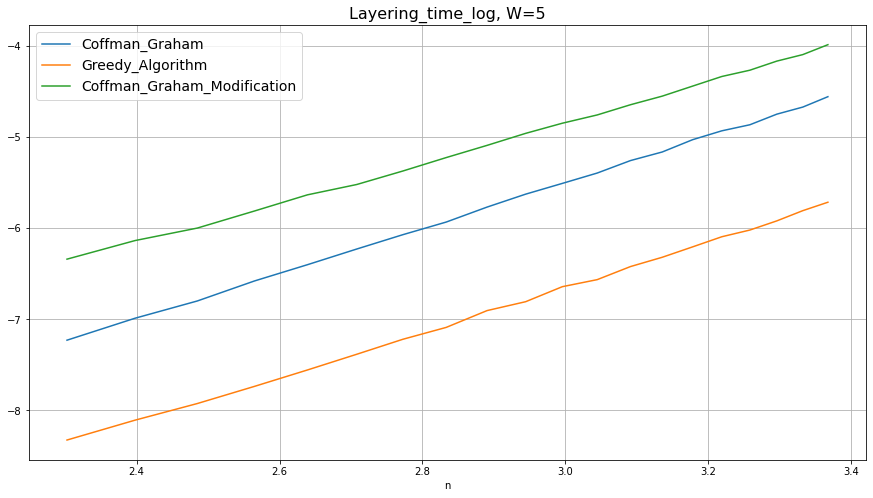

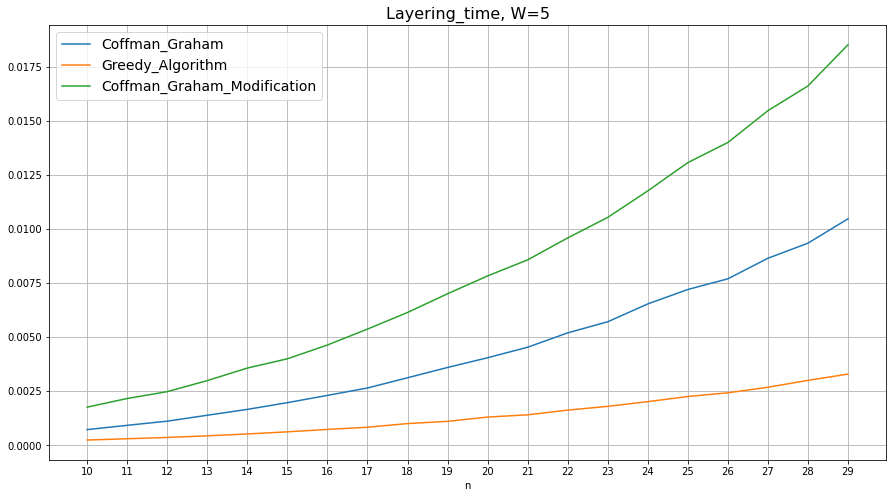

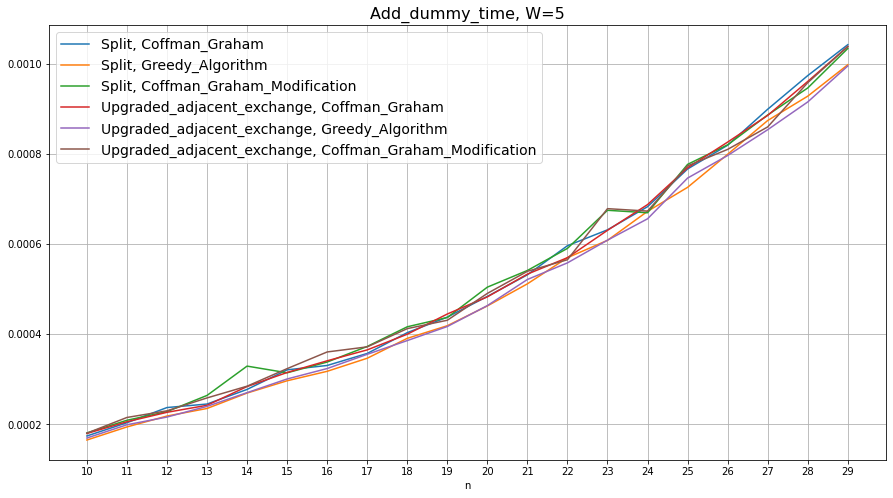

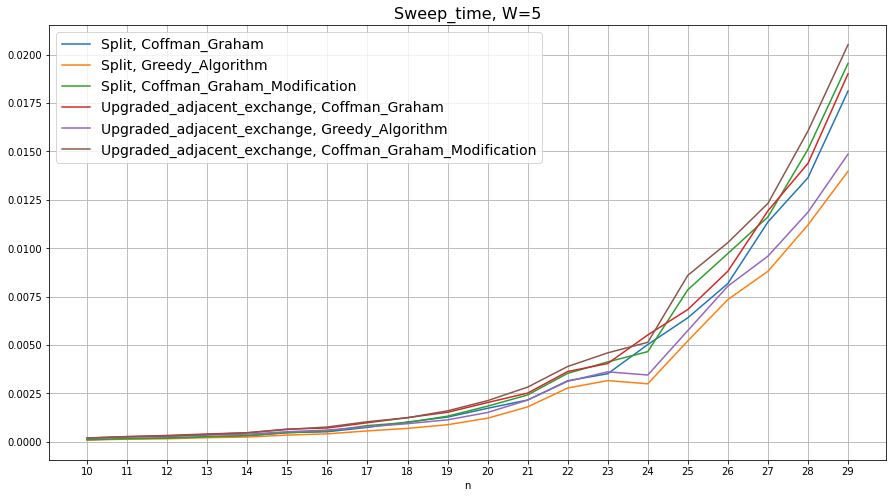

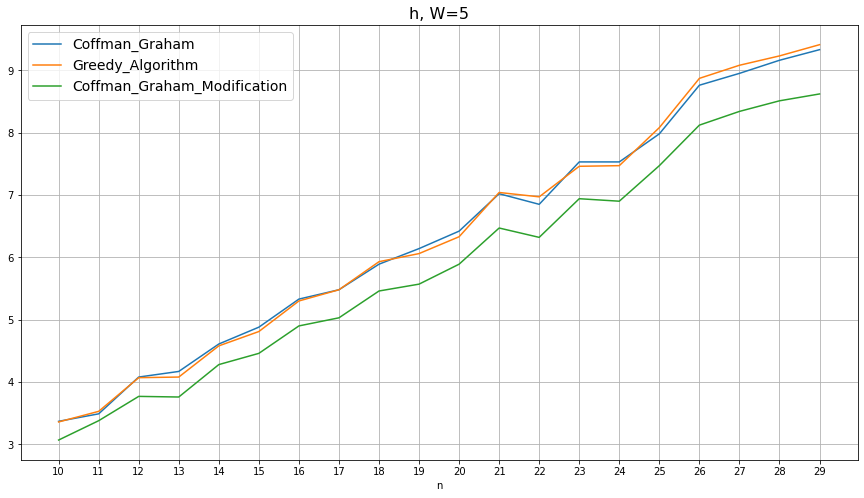

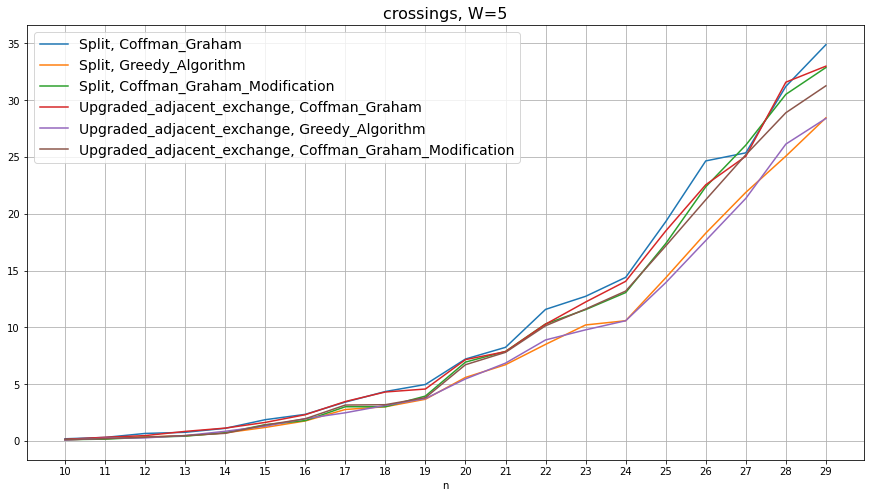

Степень зависимости (Coffman_Graham): 2.5190354869054583
Степень зависимости (Greedy_Algorithm): 2.3914813034069184
Степень зависимости (Coffman_Graham_Modification): 2.2140488105112563


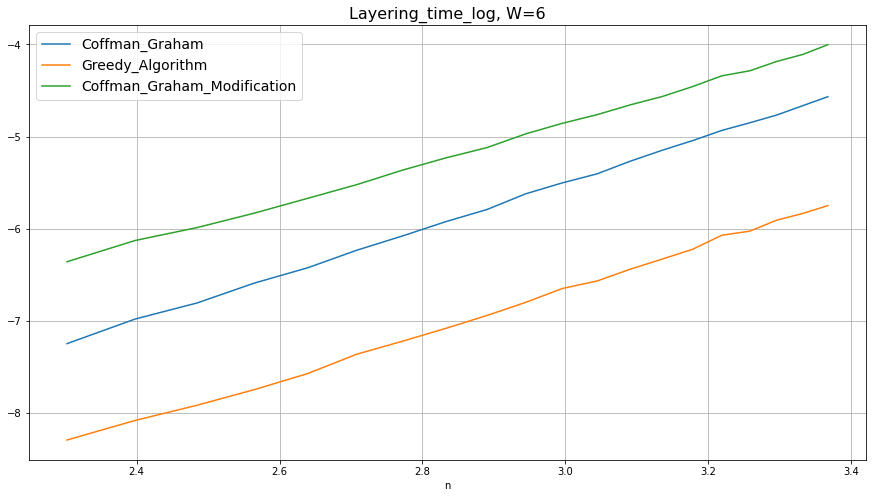

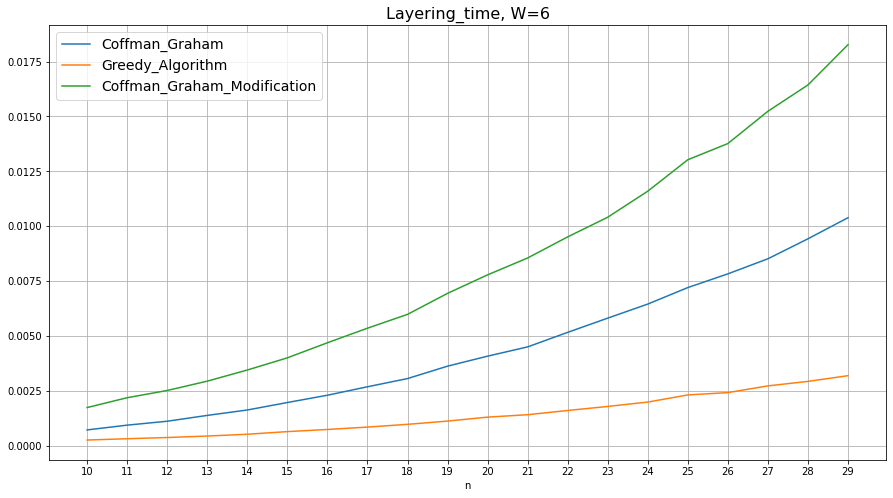

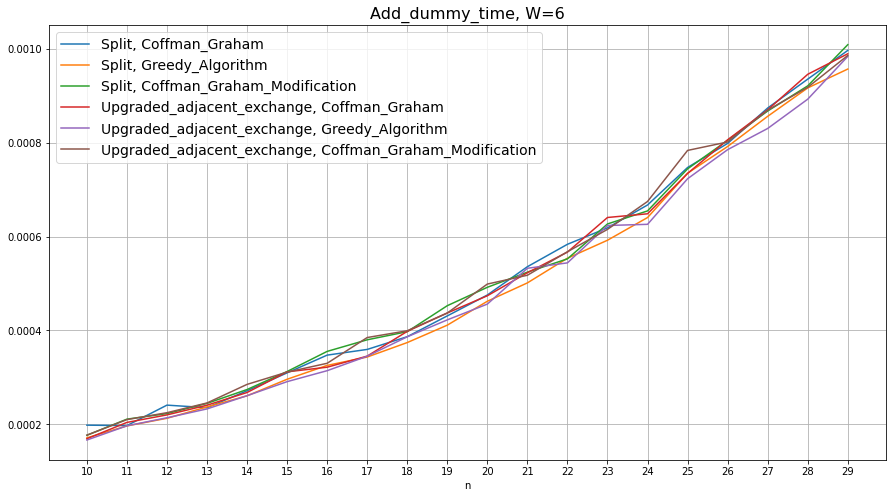

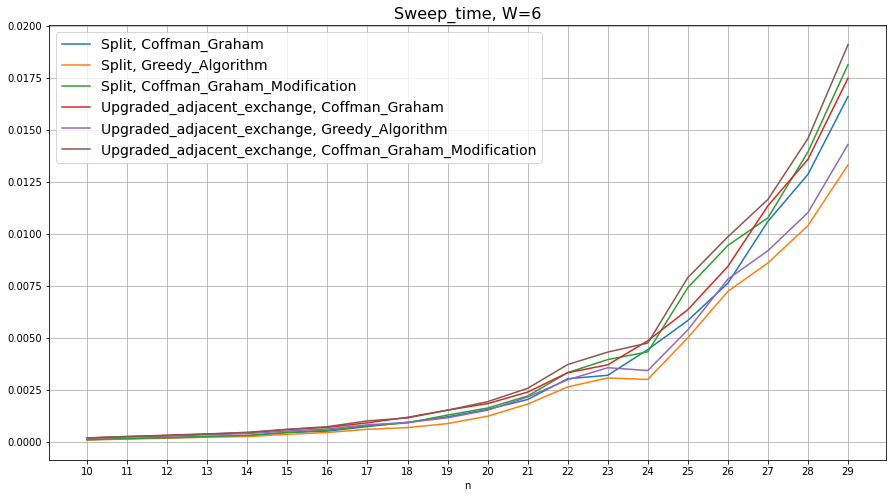

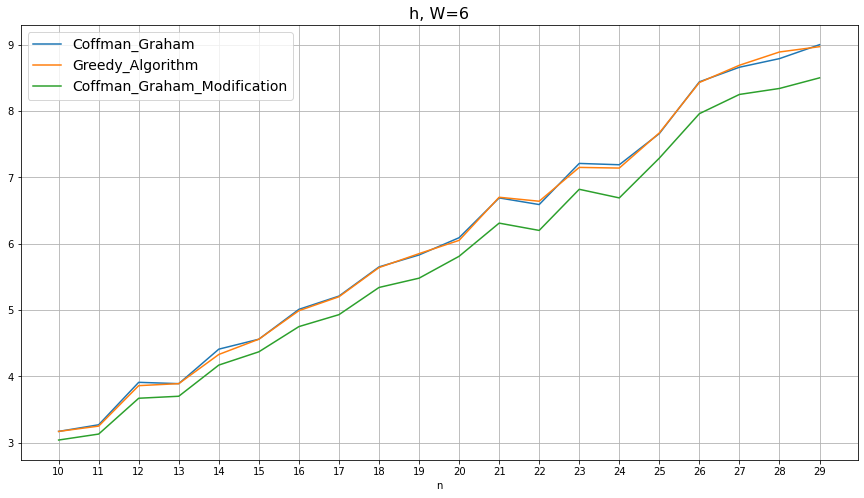

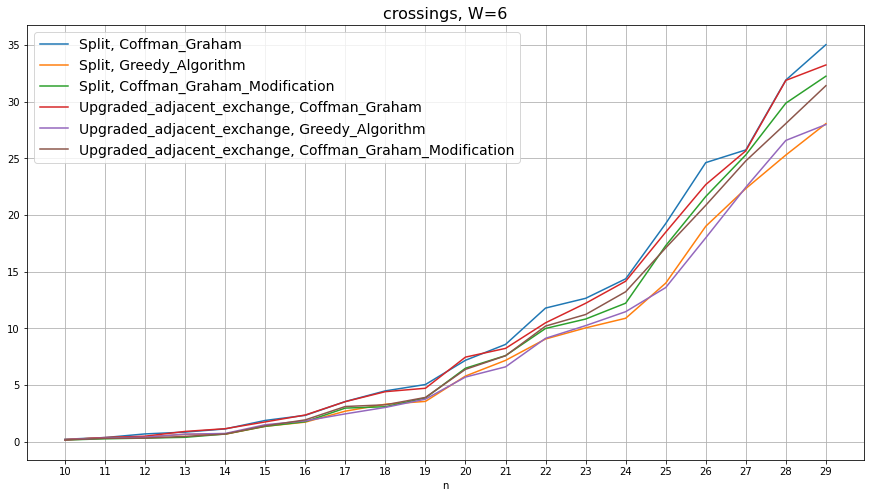

In [16]:
poly_params = ['Layering_time_log']
curr_time = time()
os.mkdir(f'./drive/MyDrive/НИР/{curr_time}')
for W in W_values:
    for k, param in enumerate(['Layering_time_log'] + params):
        plt.figure(figsize=(15, 8))
        for reductor_name in results:
            for layering_name in results[reductor_name]:
                if ('Layering' in param or param == 'h') and reductor_name != 'Split':
                    continue
                x = n_values
                y = results[reductor_name][layering_name][W][param if '_log' not in param else param[:-4]].mean(axis=1)
                if param in poly_params:
                    y = np.log(y)
                    x = np.log(x)
                label = ', '.join([reductor_name, layering_name])
                if ('Layering' in param or param == 'h'):
                    label = layering_name
                plt.plot(x, y, label=label)
                if param in poly_params:
                    print(f'Степень зависимости ({label}): {(y[-1] - y[0])/(x[-1] - x[0])}')
        plt.legend(fontsize=14)
        title = f'{param}, W={W}'
        plt.title(title, fontsize=16)
        if param not in poly_params:
            plt.xticks(n_values)
        plt.xlabel('n')
        plt.grid()
        plt.savefig(f'./drive/MyDrive/НИР/{curr_time}/{title}.png')
        plt.show()
        

In [ ]:
n_rows = 2
n_cols = 3
for W in W_values:
    k = 0
    fig, axs = plt.subplots(n_rows, n_cols)    
    fig.set_figheight(20)
    fig.set_figwidth(30)
    for k, param in enumerate(['Layering_time_log'] + params):
        row = k//n_cols
        col = k%n_cols
        for reductor_name in results:
            for layering_name in results[reductor_name]:
                x = n_values
                y = results[reductor_name][layering_name][W][param if '_log' not in param else param[:-4]].mean(axis=1)
                if param in poly_params:
                    y = np.log(y)
                    x = np.log(x)
                if param == 'Add_dummy_time':
                label = ', '.join([reductor_name, layering_name])
                if param in poly_params:
                    print(f'Степень зависимости ({label}): {(y[-1] - y[0])/(x[-1] - x[0])}')
                axs[row, col].plot(x, y, label=label)
        axs[row, col].legend()
        axs[row, col].set_title(f'{param}, W={W}')
        if param not in poly_params:
            axs[row, col].set_xticks(n_values)
            axs[row, col].set_xlabel('n')
        else:
            axs[row, col].set_xlabel('log(n)')
            axs[row, col].set_ylabel('log(t)')
        axs[row, col].grid()
    plt.show()